# Árboles de Decisión Clasificación

## 1. Librerias y configuraciones previas


In [33]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preprocesado y modelado
# ==============================================================================

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
#from sklearn.tree import export_graphviz
#from sklearn.tree import export_text


#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [34]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [35]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./datasets/02_GermanCredit_Prep.csv')

In [36]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive
#import os

#drive.mount('/gdrive')

In [37]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [38]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_account_status   1138 non-null   object
 1   loan_duration_mo          1138 non-null   int64 
 2   credit_history            1138 non-null   object
 3   purpose                   1138 non-null   object
 4   loan_amount               1138 non-null   int64 
 5   savings_account_balance   1138 non-null   object
 6   time_employed_yrs         1138 non-null   object
 7   payment_pcnt_income       1138 non-null   int64 
 8   gender_status             1138 non-null   object
 9   other_signators           1138 non-null   object
 10  time_in_residence         1138 non-null   int64 
 11  property                  1138 non-null   object
 12  age_yrs                   1138 non-null   int64 
 13  other_credit_outstanding  1138 non-null   object
 14  home_ownership          

## 4. Visualización de datos

### Variables de entrada

In [39]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,checking_account_status,credit_history,purpose,savings_account_balance,time_employed_yrs,gender_status,other_signators,property,other_credit_outstanding,home_ownership,job_category,telephone,foreign_worker
0,< 0 DM,critical account - other non-bank loans,car,< 100 DM,1 - 4 years,female-divorced/separated/married,co-applicant,real estate,none,own,skilled,none,yes
1,< 0 DM,current loans paid,car,< 100 DM,1 - 4 years,male-married/widowed,none,real estate,none,own,unskilled-resident,none,yes


In [40]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

d[numCols].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,bad_credit
0,12,3499,3,2,29,2,1,1
1,12,1168,4,3,27,1,1,0


In [41]:
##Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [42]:
##Visualización de variables numéricas
#multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [43]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('bad_credit')

### Variable de salida

In [44]:
# Distriución de la variable de salida

d.groupby('bad_credit').bad_credit.count().sort_values(ascending=False)

,bad_credit
bad_credit,
0,569
1,569


In [45]:
##Visualización de la variable de salida
#multiple_plot(1, d , None, 'bad_credit', 'countplot', 'Gráfica de frecuencia de bad Credit',0)

## 5. Transformación de datos

### Creación de variables Dummies

In [46]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 46 columns):
 #   Column                                                  Non-Null Count  Dtype
---  ------                                                  --------------  -----
 0   loan_duration_mo                                        1138 non-null   int64
 1   loan_amount                                             1138 non-null   int64
 2   payment_pcnt_income                                     1138 non-null   int64
 3   time_in_residence                                       1138 non-null   int64
 4   age_yrs                                                 1138 non-null   int64
 5   number_loans                                            1138 non-null   int64
 6   dependents                                              1138 non-null   int64
 7   bad_credit                                              1138 non-null   int64
 8   checking_account_status_< 0 DM                          11

## 6. Creación del modelo

### Dividir el conjunto de datos

In [47]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='bad_credit')
y = d['bad_credit']

In [48]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 123,
                                        shuffle      = True
                                    )

### Escalar Variables

In [49]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'time_in_residence', 'age_yrs', 'number_loans', 'dependents']


In [50]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
9,0.0294,0.1319,0.3333,0.3333,0.1667,0.0000,0.0000
798,0.5588,0.5622,0.3333,1.0000,0.4630,0.0000,1.0000


### Creación del modelos

- **criterion** (default=”gini”): Función para medir la calidad de la partición: “gini”, “entropy”, “log_loss”.
    - Gini es más rápido de calcular que la entropía, tiende a favorecer la partición de nodos que contienen clases mayoritarias en el conjunto de datos.
    - La entropía tiende a favorecer la creación de árboles más equilibrados y puede ser más útil cuando se tienen múltiples clases con distribuciones más uniformes.
Aunque ligeramente más costosa computacionalmente que Gini,
- **max_depth** (default=None): maxima profundidad del árbol
- **min_samples_split**(default=2): Mínimo de ejemplos para separar un nodo interno
- **min_samples_leaf**(default=1): Mínimo numero de ejemplos requeridos en un nodo hoja
- **ccp_alpha**: Parámetro de complejidad usado para el  Minimal Cost-Complexity de poda. Es un algoritmo que se usa para podar un árbol para evitar el over-fitting. Un ccp_alpha bajo el Árbol es más grande, riesgo de sobreajuste.


In [51]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelDtree = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelDtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

Profundidad del árbol: 5
Número de nodos terminales: 29


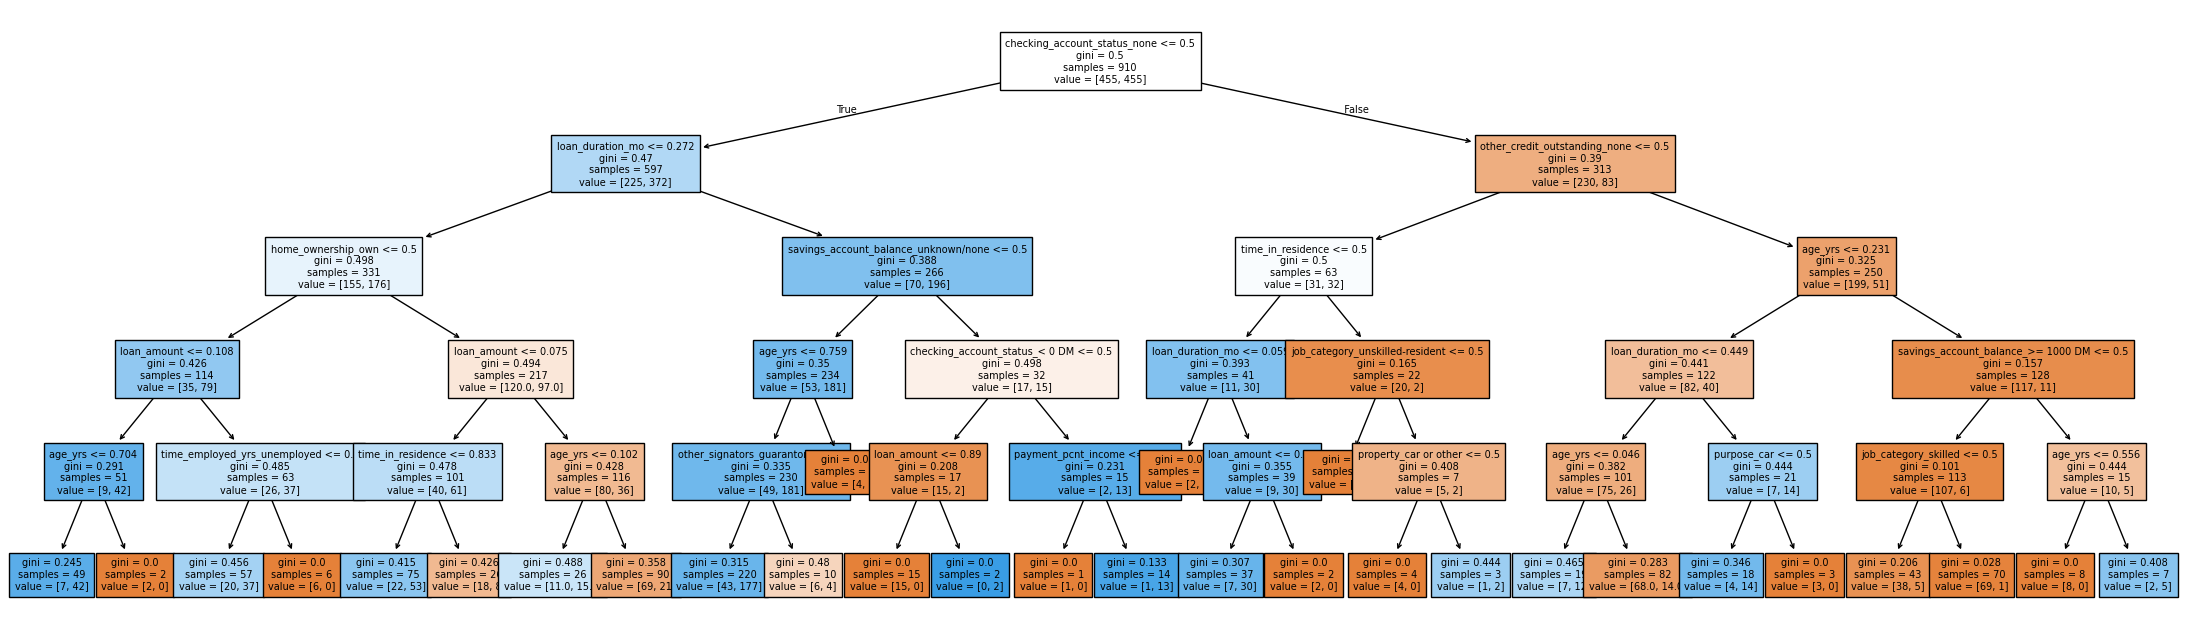

In [52]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------


fig, ax = plt.subplots(figsize=(28, 8))


print(f"Profundidad del árbol: {modelDtree.get_depth()}")
print(f"Número de nodos terminales: {modelDtree.get_n_leaves()}")

plot = plot_tree(
    decision_tree=modelDtree,
    feature_names=X.columns,
    filled=True,
    impurity=True,
    fontsize=7,
    ax=ax
)



In [53]:
y_pred = modelDtree.predict(X_test)

##### Evaluación del modelo

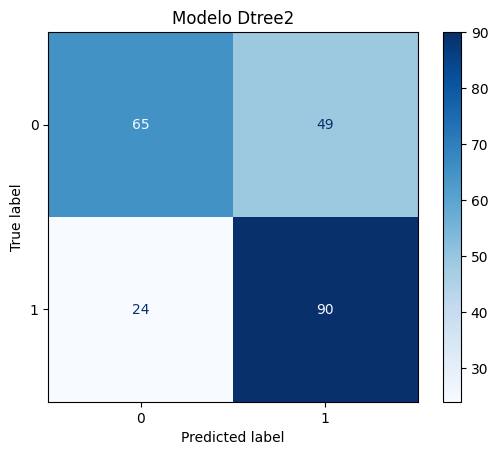

              precision    recall  f1-score   support

           0       0.73      0.57      0.64       114
           1       0.65      0.79      0.71       114

    accuracy                           0.68       228
   macro avg       0.69      0.68      0.68       228
weighted avg       0.69      0.68      0.68       228



In [54]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

# Mostrar la visualización
disp.plot(cmap='Blues')

# Configurar el título
plt.title('Modelo Dtree2')

# Mostrar la figura
plt.show()

# Mostrar el informe de clasificación
print(classification_report(y_test, y_pred))

## 7. Afinando el modelo (tuning)

In [55]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns ='bad_credit')
y = d['bad_credit']

# la validación cruzada se realiza sobre todo el dataset
X_Completo = X
y_Completo = y


In [56]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

X_Completo[num_vars].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
0,0.1176,0.2356,0.6667,0.3333,0.1667,0.3333,0.0000
1,0.1176,0.0619,1.0000,0.6667,0.1296,0.0000,0.0000


### Podado del árbol (pruning)

In [57]:
# Post pruning (const complexity pruning) por validación cruzada

# El árbol se crece al máximo posible antes de aplicar el pruning
modelTreeC= DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       )


# Definir los parámetros para la búsqueda en la cuadrícula
parameters = {'ccp_alpha': np.logspace(-6, 2, 9)} # Valores entre 0.000001 y 100 en una escala logarítmica


# Definimos las metricas sobre las que queremos evaluar
metricas = 'f1'

# definicion de la variable con el número de pliegues
CV = 10

# Búsqueda por validación cruzada
grid_TreeC = GridSearchCV(
        estimator =  modelTreeC,
        param_grid = parameters,
        scoring    = metricas,
        cv         = CV,
        refit      = True,
        return_train_score = True
      )

grid_TreeC.fit(X_Completo, y_Completo)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'ccp_alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02])},
             return_train_score=True, scoring='f1')

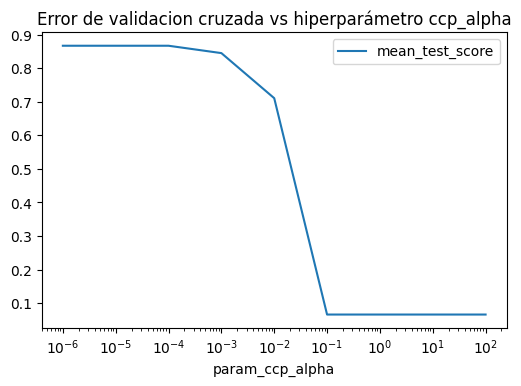

In [58]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid_TreeC.cv_results_)


# Variacion de ccp_alpha
ax.set_xscale('log')
#scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score',  ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [59]:
#pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_TreeC.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_ccp_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.0000,0.8668,0.0195,1.0000,0.0000
1,0.0000,0.8668,0.0195,1.0000,0.0000
2,0.0001,0.8668,0.0195,1.0000,0.0000
3,0.0010,0.8449,0.0288,0.9864,0.0024
4,0.0100,0.7106,0.0496,0.7323,0.0260
5,0.1000,0.0663,0.1988,0.0667,0.2001
6,1.0000,0.0663,0.1988,0.0667,0.2001
7,10.0000,0.0663,0.1988,0.0667,0.2001
8,100.0000,0.0663,0.1988,0.0667,0.2001


In [60]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid_TreeC.best_params_

{'ccp_alpha': np.float64(1e-06)}

In [61]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelDtree = grid_TreeC.best_estimator_
print(f"Profundidad del árbol: {modelDtree.get_depth()}")
print(f"Número de nodos terminales: {modelDtree.get_n_leaves()}")
print(f"Score: {grid_TreeC.best_score_}")

Profundidad del árbol: 19
Número de nodos terminales: 168
Score: 0.8668283123250975


In [62]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelDtree = DecisionTreeClassifier(
            ccp_alpha         = grid_TreeC.best_params_["ccp_alpha"],
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelDtree.fit(X_Completo, y_Completo)

DecisionTreeClassifier(ccp_alpha=np.float64(1e-06), random_state=123)

### Guardar modelo

In [63]:
#Se guarda el modelo de Árbol de decisión
joblib.dump(modelDtree, './modelos/clasificacion/DTreeC_CV.pkl')

['./modelos/clasificacion/DTreeC_CV.pkl']

## 7. Importancia de predictores

### Importancia por pureza de nodos

In [64]:
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores = pd.DataFrame(
                            {'predictor': X.columns,
                             'importancia': modelDtree.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False).head(10)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,loan_amount,0.1532
4,age_yrs,0.1198
0,loan_duration_mo,0.1183
9,checking_account_status_none,0.1083
3,time_in_residence,0.0482
2,payment_pcnt_income,0.0459
36,other_credit_outstanding_none,0.0376
27,time_employed_yrs_unemployed,0.0318
21,savings_account_balance_< 100 DM,0.0278
31,other_signators_guarantor,0.0218


#### Referencias


- Áboles de decisión
    - https://www.aprendemachinelearning.com/arbol-de-decision-en-python-clasificacion-y-prediccion/
    - https://www.cienciadedatos.net/documentos/py07_arboles_decision_python.html